In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load packages

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
import tensorflow_addons as tfa
import pickle


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### parameters

In [5]:
dataset = "fmnist"
labels_per_class = 64 # 'full'
n_latent_dims = 1024
confidence_threshold = 0.0 # minimum confidence to include in UMAP graph for learned metric
learned_metric = False # whether to use a learned metric, or Euclidean distance between datapoints

augmented = False #
min_dist= 0.001 # min_dist parameter for UMAP
negative_sample_rate = 5 # how many negative samples per positive sample 
batch_size = 128 # batch size 
optimizer = tf.keras.optimizers.Adam(1e-3) # the optimizer to train
optimizer = tfa.optimizers.MovingAverage(optimizer)
label_smoothing = 0.2 # how much label smoothing to apply to categorical crossentropy
max_umap_iterations = 500 # how many times, maximum, to recompute UMAP
max_epochs_per_graph = 10 # how many epochs maximum each graph trains for (without early stopping)
graph_patience = 10 # how many times without improvement to train a new graph
min_graph_delta = 0.0025 # minimum improvement on validation acc to consider an improvement for training

In [6]:
from datetime import datetime

datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(confidence_threshold)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_umap_augmented'
)
print(datestring)

fmnist_0.0_64____2020_08_23_19_43_20_063919_umap_augmented


#### Load dataset

In [7]:
from tfumap.semisupervised_keras import load_dataset

In [8]:
(
    X_train,
    X_test,
    X_labeled,
    Y_labeled,
    Y_masked,
    X_valid,
    Y_train,
    Y_test,
    Y_valid,
    Y_valid_one_hot,
    Y_labeled_one_hot,
    num_classes,
    dims
) = load_dataset(dataset, labels_per_class)

### load architecture

In [9]:
from tfumap.semisupervised_keras import load_architecture

In [10]:
encoder, classifier, embedder = load_architecture(dataset, n_latent_dims)

### load pretrained weights

In [11]:
from tfumap.semisupervised_keras import load_pretrained_weights

In [12]:
!ls /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/semisupervised-keras/mnist/64

mnist_0.0_64____2020_08_23_18_31_15_922443_umap_augmented
mnist_0.0_64____2020_08_23_18_32_38_592348_umap_augmented
mnist_64____2020_08_23_14_13_19_397319_baseline


In [13]:
!ls /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/semisupervised-keras/fmnist/4

fmnist_0.0_4____2020_08_23_18_48_03_409056_umap_augmented
fmnist_4____2020_08_23_14_15_38_194490_baseline


In [14]:
encoder, classifier = load_pretrained_weights(dataset, augmented, labels_per_class, encoder, classifier)

W0823 19:43:26.032442 140196765808384 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f8115d619e8> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f8115d61a20>).
W0823 19:43:26.034561 140196765808384 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f8115c7dc88> and <tensorflow.python.keras.layers.advanced_activations.

W0823 19:43:26.583738 140196765808384 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f8115fac1d0> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f8115fac4e0>).
W0823 19:43:26.588349 140196765808384 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f8115fac4e0> and <tensorflow.python.keras.layers.adv

#### compute pretrained accuracy

In [15]:
# test current acc
pretrained_predictions = classifier.predict(encoder.predict(X_test, verbose=True), verbose=True)
pretrained_predictions = np.argmax(pretrained_predictions, axis=1)
pretrained_acc = np.mean(pretrained_predictions == Y_test)
print('pretrained acc: {}'.format(pretrained_acc))

313/313 [==============================] - 1s 4ms/step
pretrained acc: 0.8351


### get a, b parameters for embeddings

In [16]:
from tfumap.semisupervised_keras import find_a_b

In [17]:
a_param, b_param = find_a_b(min_dist=min_dist)

### build network

In [18]:
from tfumap.semisupervised_keras import build_model

In [19]:
model = build_model(
    batch_size=batch_size,
    a_param=a_param,
    b_param=b_param,
    dims=dims,
    encoder=encoder,
    classifier=classifier,
    negative_sample_rate=negative_sample_rate,
    optimizer=optimizer,
    label_smoothing=label_smoothing,
    embedder = embedder,
)

### build labeled iterator

In [20]:
from tfumap.semisupervised_keras import build_labeled_iterator

In [21]:
labeled_dataset = build_labeled_iterator(X_labeled, Y_labeled_one_hot, augmented, dims)

### training

In [22]:
from livelossplot import PlotLossesKerasTF
from tfumap.semisupervised_keras import get_edge_dataset
from tfumap.semisupervised_keras import zip_datasets

#### callbacks

In [23]:
# plot losses callback
groups = {'acccuracy': ['classifier_accuracy', 'val_classifier_accuracy'], 'loss': ['classifier_loss', 'val_classifier_loss']}
plotlosses = PlotLossesKerasTF(groups=groups)

In [24]:
history_list = []
current_validation_acc = 0
batches_per_epoch = np.floor(len(X_train)/batch_size).astype(int)
epochs_since_last_improvement = 0
current_umap_iterations = 0
current_epoch = 0

In [25]:
# make dataset
edge_dataset = get_edge_dataset(
    model,
    augmented,
    classifier,
    encoder,
    X_train,
    Y_masked,
    batch_size,
    confidence_threshold,
    labeled_dataset,
    dims,
    learned_metric = learned_metric
)

# zip dataset
zipped_ds = zip_datasets(labeled_dataset, edge_dataset, batch_size)

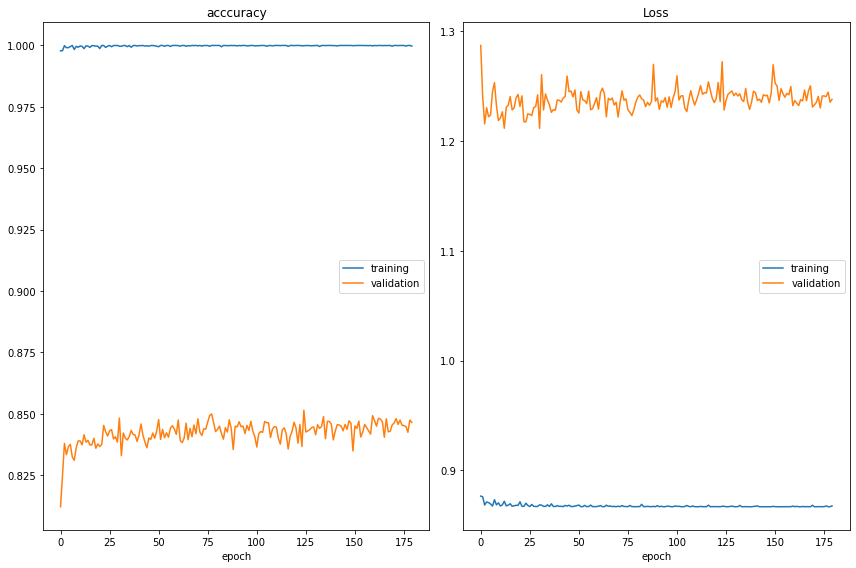

acccuracy
	training         	 (min:    0.998, max:    1.000, cur:    1.000)
	validation       	 (min:    0.812, max:    0.851, cur:    0.846)
Loss
	training         	 (min:    0.867, max:    0.877, cur:    0.868)
	validation       	 (min:    1.211, max:    1.287, cur:    1.238)
390/390 [==============================] - 73s 187ms/step - loss: 0.9801 - classifier_loss: 0.8677 - umap_loss: 0.1124 - classifier_accuracy: 0.9998 - val_loss: 1.2378 - val_classifier_loss: 1.2378 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.8465
Early stopping


In [26]:
from tfumap.paths import MODEL_DIR, ensure_dir
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder / 'test_loss.npy')

for cui in tqdm(np.arange(current_epoch, max_umap_iterations)):
    
    if len(history_list) > graph_patience+1:
        previous_history = [np.mean(i.history['val_classifier_accuracy']) for i in history_list]
        best_of_patience = np.max(previous_history[-graph_patience:])
        best_of_previous = np.max(previous_history[:-graph_patience])
        if (best_of_previous + min_graph_delta) > best_of_patience:
            print('Early stopping')
            break
    
    # train dataset
    history = model.fit(
        zipped_ds,
        epochs= current_epoch + max_epochs_per_graph,
        initial_epoch = current_epoch,
        validation_data=(
            (X_valid, tf.zeros_like(X_valid), tf.zeros_like(X_valid)),
            {"classifier": Y_valid_one_hot},
        ),
        callbacks = [plotlosses],
        max_queue_size = 100,
        steps_per_epoch = batches_per_epoch,
        #verbose=0
    )
    current_epoch+=len(history.history['loss'])
    history_list.append(history)
    
    # save score 
    class_pred = classifier.predict(encoder.predict(X_test))
    class_acc = np.mean(np.argmax(class_pred, axis=1) == Y_test)
    np.save(save_folder / 'test_loss.npy', (np.nan, class_acc))
    
    # save weights
    encoder.save_weights((save_folder / "encoder").as_posix())
    classifier.save_weights((save_folder / "classifier").as_posix())
    
    # save history
    with open(save_folder / 'history.pickle', 'wb') as file_pi:
        pickle.dump([i.history for i in history_list], file_pi)

        current_umap_iterations += 1

In [27]:
previous_history = [np.mean(i.history['val_classifier_accuracy']) for i in history_list]
best_of_patience = np.max(previous_history[-graph_patience:])
best_of_previous = np.max(previous_history[:-graph_patience])
if (best_of_previous + min_graph_delta) > best_of_patience:
    print('Early stopping')

Early stopping


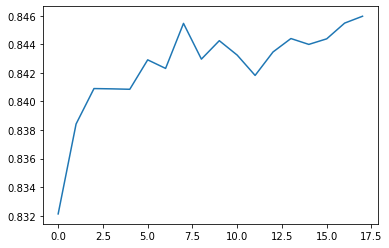

In [28]:
plt.plot(previous_history)

### save embedding

In [29]:
z = encoder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug 23 23:38:07 2020 Finding Nearest Neighbors
Sun Aug 23 23:38:07 2020 Building RP forest with 16 trees
Sun Aug 23 23:38:08 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
Sun Aug 23 23:38:21 2020 Finished Nearest Neighbor Search
Sun Aug 23 23:38:23 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Aug 23 23:38:56 2020 Finished embedding


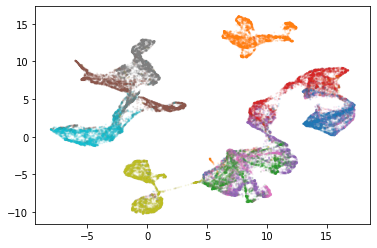

In [30]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [31]:
np.save(save_folder / 'train_embedding.npy', embedding)